# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
-
-
-


## Part 1: 
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.

## Problem Motivation 

The stock market changes every day, and investors often try to predict whether prices will rise or fall. While stock prices are influenced by many factors, we believe that historical trading data still contains valuable patterns that can help make predictions. In this project, we will use Apple’s (AAPL) historical stock data to explore whether features such as daily percent change, trading volume, and moving averages can help forecast the next day’s closing price.

### The key questions we aim to answer are:

##### 1) Which historical features (e.g., percent change, volume, moving averages) are most predictive of tomorrow’s closing price?

##### 2) How accurately can we predict the next day’s closing price using historical data?

### Motivating sources:

Yahoo Finance. "AAPL Historical Data." Yahoo Finance, https://finance.yahoo.com/quote/AAPL/history
. Accessed 26 Oct. 2025.

Investopedia. "Technical Analysis of Stocks." Investopedia, https://www.investopedia.com/terms/t/technicalanalysis.asp
. Accessed 26 Oct. 2025.

## Summary of the Data Processing Pipeline

1) Collect data: Retrieve historical stock data using the Yahoo Finance API (yfinance).

2) Clean the data: Handle missing values, filter relevant columns, and compute derived features like moving averages and daily percent changes.

3) Visualize trends: Use plotting libraries like Matplotlib, Seaborn, and Plotly to explore patterns and relationships in the data.

4) Prepare for modeling: Select relevant features and split the data into training and testing sets for predictive modeling.

To process the data, we will first acquire Apple’s historical stock data using the yfinance API. After collection, we will clean the data by removing missing or inconsistent values, computing features like daily percent change and moving averages, and converting dates to a usable format. Next, we will visualize trends in the stock data, such as price changes over time, correlations with trading volume, and other patterns that may inform predictions. Finally, the cleaned data will be prepared for predictive modeling, where we will train and test models to forecast next-day closing prices. This workflow will help us answer our key questions and assess the potential of historical stock features in predicting market movements.

## Part 2: 
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [1]:
# Importing Necessary Libraries
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import os

/Users/vitakhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Function to clean the dataset
def clean_data(df):
    """ 
    Cleans the dataframe by doing the following:
        - Converting columns to datetime.
        - Handling missing or invalid values.
        - Removing unnecessary columns.
        - Converting categorical values like gender.
        - Removing outliers in tripduration.

    Args: 
        df (pd.DataFrame) : a data frame to clean

    Returns:
        df (pd.DataFrame) : cleaned data frame
    """

    # Removing 'n/a', newline characters, and '\N' from all string columns (we noticed these parts in the raw dataset)
    df.replace({"n/a": pd.NA, "\n": pd.NA, r"\N": pd.NA}, inplace=True)

    # Converting 'starttime' and 'stoptime' to datetime format
    df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
    df['stoptime'] = pd.to_datetime(df['stoptime'], errors='coerce')

    # Converting tripduration from seconds to minutes (if needed)
    if df['tripduration'].max() > 10000:  # Assume it's in seconds if large
        df['tripduration'] = df['tripduration'] / 60  # Convert to minutes

    # Removing invalid or zero trip durations
    df = df[df['tripduration'] > 0]

    # Removing rows with missing data in specific important columns
    df.dropna(subset=['starttime', 'stoptime', 'start station id', 'end station id', 'bikeid', 'usertype'], inplace=True)

    # Removing any rows with 'n/a' or missing values in other relevant columns, including 'birth year'
    df.dropna(inplace=True)

    # Converting gender (0 = Unknown, 1 = Male, 2 = Female)
    if 'gender' in df.columns:
        df['gender'] = df['gender'].map({0: 'Unknown', 1: 'Male', 2: 'Female'})

    # Removing unrealistic trip durations (ex. over 1000 minutes)
    df = df[df['tripduration'] < 1000]

    return df


# This is the URL of the website hosting the zip files
url = 'https://s3.amazonaws.com/hubway-data'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Initializing a list to hold the links to zip files
zip_links = []
for download_link in soup.find_all('key'):
    # Extracting the 'key' element text
    zip_file_name = download_link.text
    # Appending the URL for zip files to the list if it ends with .zip
    if zip_file_name.endswith('.zip'):
        zip_links.append(f"https://s3.amazonaws.com/hubway-data/{zip_file_name}")

# Creating directory to save CSV files if not exists
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

# Processing each zip file link and cleaning the data
first_csv_path = None
for i, zip_url in enumerate(zip_links):
    try:
        # Downloading the ZIP file
        zip_response = requests.get(zip_url)
        zip_response.raise_for_status()  # Check for download errors

        # Extracting the ZIP file
        with ZipFile(BytesIO(zip_response.content)) as zip_file:
            for zip_info in zip_file.infolist():
                if zip_info.filename.endswith('.csv'):
                    try:
                        # Extracting the CSV file into a DataFrame
                        with zip_file.open(zip_info) as extracted_file:
                            df = pd.read_csv(extracted_file)
                            print(f"Extracted {zip_info.filename} to DataFrame.")

                            # Cleaning the data using the clean_data function
                            df_cleaned = clean_data(df)

                            # Saving cleaned DataFrame to a CSV file
                            output_filename = f"csv_files/cleaned_{i+1}_{zip_info.filename}"
                            df_cleaned.to_csv(output_filename, index=False)
                            print(f"Saved cleaned {zip_info.filename} to {output_filename}.")

                            if first_csv_path is None:
                                first_csv_path = output_filename
                    except Exception as e:
                        print(f"Error processing {zip_info.filename}: {e}")
                        continue  
    
    except Exception as e:
        print(f"Error downloading or extracting {zip_url}: {e}")
        continue  

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Extracted 201501-hubway-tripdata.csv to DataFrame.
Saved cleaned 201501-hubway-tripdata.csv to csv_files/cleaned_1_201501-hubway-tripdata.csv.
Extracted 201502-hubway-tripdata.csv to DataFrame.
Saved cleaned 201502-hubway-tripdata.csv to csv_files/cleaned_2_201502-hubway-tripdata.csv.
Extracted 201503-hubway-tripdata.csv to DataFrame.
Saved cleaned 201503-hubway-tripdata.csv to csv_files/cleaned_3_201503-hubway-tripdata.csv.
Extracted 201504-hubway-tripdata.csv to DataFrame.
Saved cleaned 201504-hubway-tripdata.csv to csv_files/cleaned_4_201504-hubway-tripdata.csv.
Extracted 201505-hubway-tripdata.csv to DataFrame.
Saved cleaned 201505-hubway-tripdata.csv to csv_files/cleaned_5_201505-hubway-tripdata.csv.
Extracted 201506-hubway-tripdata.csv to DataFrame.
Saved cleaned 201506-hubway-tripdata.csv to csv_files/cleaned_6_201506-hubway-tripdata.csv.
Extracted 201507-hubway-tripdata.csv to DataFrame.
Saved cleaned 201507-hubway-tripdata.csv to csv_files/cleaned_7_201507-hubway-tripdata.csv.

In [3]:
# Test
# Printing first 50 rows of the first cleaned CSV file
if first_csv_path:
    df_first_csv = pd.read_csv(first_csv_path)
    print(df_first_csv.head(50))
else:
    print("No CSV file was extracted and cleaned.")

    tripduration            starttime             stoptime  start station id  \
0       9.033333  2015-01-01 00:21:44  2015-01-01 00:30:47               115   
1       7.300000  2015-01-01 00:27:03  2015-01-01 00:34:21                80   
2       4.233333  2015-01-01 00:31:31  2015-01-01 00:35:46                91   
3       7.200000  2015-01-01 00:53:46  2015-01-01 01:00:58               115   
4      12.250000  2015-01-01 01:07:06  2015-01-01 01:19:21               105   
5       5.183333  2015-01-01 01:28:27  2015-01-01 01:33:38                88   
6      20.983333  2015-01-01 01:34:54  2015-01-01 01:55:54                91   
7       5.633333  2015-01-01 02:32:35  2015-01-01 02:38:13                68   
8       7.150000  2015-01-01 04:41:58  2015-01-01 04:49:08               117   
9       4.816667  2015-01-01 08:00:15  2015-01-01 08:05:04                67   
10      4.600000  2015-01-01 08:22:12  2015-01-01 08:26:48                75   
11     24.600000  2015-01-01 08:29:05  2

## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [4]:
# importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

This is a reuse of code from the previous section, but instead of
saving the data to csv files, instead it compiles the data in a 
dataframe with all of the data. The data must be compiled this way
because csvs do not preserve object type such as datetime.
The reason that this is a new code snippet is because compiling the 
full dataframe in the previous snippet would remake all the csvs every time
the variables were reset.


In [5]:
# This is the URL of the website hosting the zip files
url = 'https://s3.amazonaws.com/hubway-data'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Initializing a list to hold the links to zip files
zip_links = []
for download_link in soup.find_all('key'):
    # Extracting the 'key' element text
    zip_file_name = download_link.text
    # Appending the URL for zip files to the list if it ends with .zip
    if zip_file_name.endswith('.zip'):
        zip_links.append(f"https://s3.amazonaws.com/hubway-data/{zip_file_name}")

# Initializing the final full dataset to use for the plots
full_dataset = pd.DataFrame()

# Processing each zip file link and cleaning the data
first_csv_path = None
for i, zip_url in enumerate(zip_links):
    try:
        # Downloading the ZIP file
        zip_response = requests.get(zip_url)
        zip_response.raise_for_status()  # Check for download errors

        # Extracting the ZIP file
        with ZipFile(BytesIO(zip_response.content)) as zip_file:
            for zip_info in zip_file.infolist():
                if zip_info.filename.endswith('.csv'):
                    try:
                        # Extracting the CSV file into a DataFrame
                        with zip_file.open(zip_info) as extracted_file:
                            df = pd.read_csv(extracted_file)
                            
                            # Cleaning the data using the clean_data function
                            df_cleaned = clean_data(df)

                            # Combining data into full Dataframe 
                            full_dataset = pd.concat([full_dataset, df_cleaned])
                            
                            if first_csv_path is None:
                                first_csv_path = output_filename
                    except Exception as e:
                        continue  
    
    except Exception as e:
        continue 

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


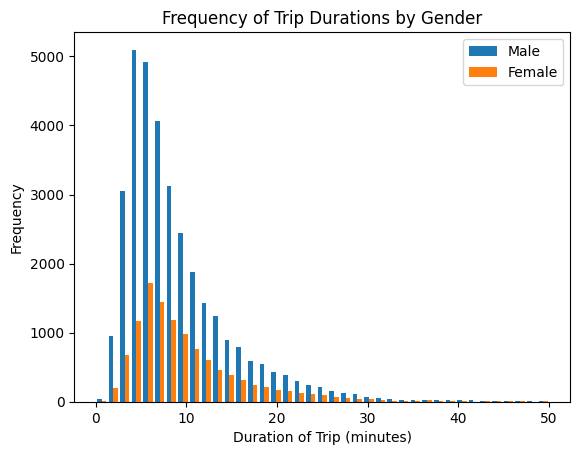

In [6]:
# plotting with the appropriate data
hist_plot = full_dataset.head(45000)

# setting bin size
bins = np.linspace(0, 50, 40)

# grouping by gender
groups = hist_plot.groupby('gender')

# setting up histogram
plt.style.use('default')
plt.hist([groups.get_group('Male')['tripduration'], groups.get_group('Female')['tripduration']], bins, label=['Male', 'Female'])
plt.legend(loc='upper right')
plt.title('Frequency of Trip Durations by Gender')
plt.xlabel('Duration of Trip (minutes)')
plt.ylabel('Frequency')
plt.show()

# Please see screenshots attached in case Gradescope does not show the plot

By visualizing this histogram, we can see the frequency distribution of trip durations by gender and answer one of the key questions we had - 'How does bike trip duration vary by user type (eg. gender)?' In our case, we can observe that males tend to take more frequently than females. We can also conclude that the most common trip lengths are roughly between 5 to 8 minutes, and both genders prefer short trips (less than 10 minutes). Moreover, based on the user preferences, long trips (longer than 30 mins) happen rarely.

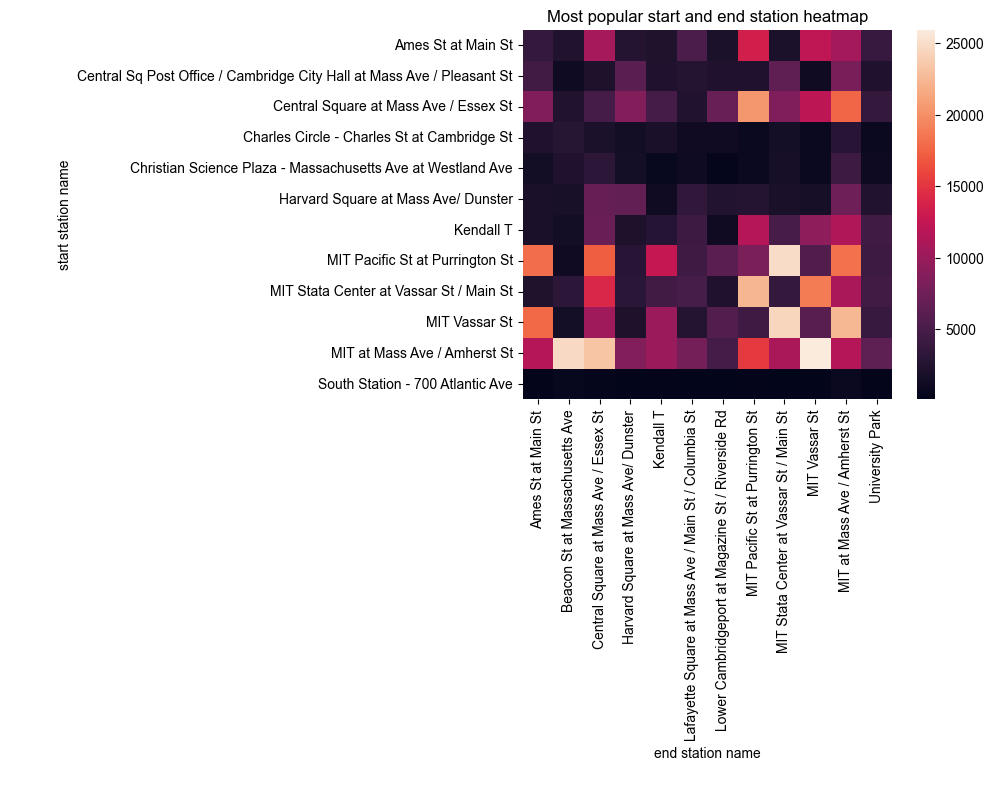

In [7]:
# sorting groups by start station name, and creates list of station popularity 
sorted_groups = full_dataset.groupby('start station name')
group_names = sorted_groups.size().sort_values(ascending=False) 

# adding the 12 most popular start stations into the working dataframe
partial = pd.DataFrame()
for i in range(12):
    cur_group = group_names.index[i]
    partial = pd.concat([partial, sorted_groups.get_group(cur_group)])

# sorting groups by end station name, and creates list of station popularity 
sorted_groups = partial.groupby('end station name')
group_names = sorted_groups.size().sort_values(ascending=False) 

# adding the 12 most popular end stations into the working dataframe
partial = pd.DataFrame()
for i in range(12):
    cur_group = group_names.index[i]
    partial = pd.concat([partial, sorted_groups.get_group(cur_group)])

# creating pivot table to initilize heatmap
pivot_df = partial.pivot_table(index='start station name', 
                                    columns='end station name', 
                                    values='tripduration', 
                                    aggfunc='count')

# creating heatmap
sns.heatmap(pivot_df, annot=False, square=True)
plt.title('Most popular start and end station heatmap')
sns.set(font_scale=.8)

# Please see screenshots attached in case Gradescope does not show the plot

The heatmap shows the most popular start and end stations mapping and answers the question 'Which stations have the highest traffic, and how does the distribution of bike usage vary geographically? Can we identify high-demand areas that would benefit from more bikes?'. We can clearly observe the light beige colors around locations like MIT area, specifically MIT Pacific St at Purrington St and MIT Stata Center at Vassar St/Main St, which indicates the highest traffic and number of trips between stations in that area. On the other hand, we can see low number of trips from South Station. Overall, this heatmap can be helpful when analyzing the distribution of bike usage across stations and also identify high-demand areas, so that the appropriate number of bikes and stations could be installed and supplied in the popular areas.

In [13]:
# getting the hours from starttime
full_dataset['hour'] = full_dataset['starttime'].dt.hour

# grouping by hour in order to count the number of trips per hour
hourly_trips = full_dataset.groupby('hour').size().reset_index(name='trip_count')

# making a plot
fig = px.line(hourly_trips, x='hour', y='trip_count', title='Number of Bike Trips by Hour of the Day', labels={'hour': 'Hour of Day', 'trip_count': 'Number of Trips'})

# updating the layout to center the title
fig.update_layout(title_x=0.5)
fig.show('iframe')

# Please see screenshots attached in case Gradescope does not show the plot

![LinePlot](plot_screenshots/lineplot.png)

This line plot shows the trend in the number of bike trips per hour based on the start time of the trip. It highlights the peak of bike usage and answers the question 'Are there peaks in bike usage during certain times of the day?'. We can observe the two peaks, one in the morning at around 8 am, indicating people used bikes to commute to stations or to work, and another one in the evening at 5 pm, meaning people used bikes to commute back to stations or home. Overall, we can see the trend that people tend to use bikes in the evening more than in the morning, with the highest peak at 5 pm.